In [ ]:
!pip install kaggle pretty_midi torch torchvision torchaudio scikit-learn matplotlib tqdm > /dev/null

from google.colab import drive
drive.mount('/content/drive')

import os, re, json, glob, zipfile, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------
# 1) Konfigurasi path & unduh ZIP
# -------------------------
FILE_ID = "1VPx3nKsEPR-GV9v0QiNZRbA_Ptdt7lsA"   # ID ZIP gabungan (punyamu)
ZIP_PATH = Path("/content/dataset_mirex.zip")
EXTRACT_DIR = Path("/content/dataset_mirex")    # root ekstraksi

SAVE_DIR = Path("/content/drive/MyDrive/dataset_mirex/miditrainX")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

import gdown
if not ZIP_PATH.exists():
    print("Downloading ZIP via gdown...")
    gdown.download(id=FILE_ID, output=str(ZIP_PATH), quiet=False)
else:
    print("ZIP already exists:", ZIP_PATH)

print("Extracting ZIP ...")
EXTRACT_DIR.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(ZIP_PATH, 'r') as zf:
    zf.extractall(EXTRACT_DIR)

print("Done extract.")
print("EXTRACT_DIR content:")
for p in EXTRACT_DIR.iterdir():
    print(" -", p)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ZIP already exists: /content/dataset_mirex.zip
Extracting ZIP ...
Done extract.
EXTRACT_DIR content:
 - /content/dataset_mirex/dataset
 - /content/dataset_mirex/best_lyrics_bert.pt
 - /content/dataset_mirex/lyrics_prob_for_fusion.csv
 - /content/dataset_mirex/README.txt


In [ ]:
from pathlib import Path
import os

EXTRACT_DIR = Path("/content/dataset_mirex")

# Cari folder yang punya subfolder Audio, Lyrics, MIDIs
candidates = []
for root, dirs, files in os.walk(EXTRACT_DIR):
    dirs_set = set(dirs)
    if {"Audio", "Lyrics", "MIDIs"}.issubset(dirs_set):
        candidates.append(Path(root))

if not candidates:
    raise RuntimeError("Gak nemu folder yang berisi Audio, Lyrics, MIDIs di bawah /content/dataset_mirex")

ROOT = candidates[0]
AUDIO_DIR = ROOT / "Audio"
LYRIC_DIR = ROOT / "Lyrics"
MIDI_DIR  = ROOT / "MIDIs"

print("ROOT terdeteksi :", ROOT)
print("AUDIO_DIR       :", AUDIO_DIR)
print("LYRIC_DIR       :", LYRIC_DIR)
print("MIDI_DIR        :", MIDI_DIR)

# Cari file .bat di bawah ROOT
BAT_FILES = sorted(ROOT.rglob("split-by-categories*.bat"))
print("\nBAT_FILES ditemukan:", len(BAT_FILES))
for b in BAT_FILES:
    print(" -", b)


ROOT terdeteksi : /content/dataset_mirex/dataset
AUDIO_DIR       : /content/dataset_mirex/dataset/Audio
LYRIC_DIR       : /content/dataset_mirex/dataset/Lyrics
MIDI_DIR        : /content/dataset_mirex/dataset/MIDIs

BAT_FILES ditemukan: 3
 - /content/dataset_mirex/dataset/split-by-categories-audio.bat
 - /content/dataset_mirex/dataset/split-by-categories-lyrics.bat
 - /content/dataset_mirex/dataset/split-by-categories-midi.bat


In [ ]:
import pandas as pd

DRIVE_DATASET_DIR = Path("/content/drive/MyDrive/dataset_mirex")
DATASET_ROOT = EXTRACT_DIR   # /content/dataset_mirex

master_tracks = pd.read_csv(DRIVE_DATASET_DIR / "master_tracks.csv")
split_global  = pd.read_csv(DRIVE_DATASET_DIR / "split_global.csv")

print("master_tracks:", master_tracks.shape)
print("split_global :", split_global.shape)
master_tracks.head()


master_tracks: (903, 8)
split_global : (903, 2)


,file_id,file_id_norm,emotion,label_id,label_idx,has_audio,has_lyrics,has_midi
0,1,1,Cluster 1,1,0,1,1,0
1,2,2,Cluster 1,1,0,1,0,0
2,3,3,Cluster 1,1,0,1,1,0
3,4,4,Cluster 1,1,0,1,1,1
4,5,5,Cluster 1,1,0,1,0,0


In [ ]:
from pathlib import Path

# Gabung master_tracks dengan split_global
df = master_tracks.merge(split_global, left_on="file_id_norm", right_on="id", how="inner")

# Filter hanya lagu yang punya lirik
df_lyrics = df[df["has_lyrics"] == 1].copy()
print("Jumlah lagu yang punya lirik:", len(df_lyrics))

# Tambah path file lirik
df_lyrics["lyrics_path"] = df_lyrics["file_id"].apply(lambda fid: LYRIC_DIR / f"{fid}.txt")

# Cek apakah ada file yang hilang
missing = [p for p in df_lyrics["lyrics_path"] if not p.exists()]
print("Missing lyrics files:", len(missing))
if missing:
    print("Contoh missing:", missing[:5])


Jumlah lagu yang punya lirik: 764
Missing lyrics files: 78
Contoh missing: [PosixPath('/content/dataset_mirex/dataset/Lyrics/1.txt'), PosixPath('/content/dataset_mirex/dataset/Lyrics/3.txt'), PosixPath('/content/dataset_mirex/dataset/Lyrics/4.txt'), PosixPath('/content/dataset_mirex/dataset/Lyrics/7.txt'), PosixPath('/content/dataset_mirex/dataset/Lyrics/8.txt')]


In [ ]:
def read_txt(path: Path):
    try:
        with open(path, "r", encoding="utf-8", errors="ignore") as f:
            return f.read()
    except Exception:
        return ""

df_lyrics["text"] = df_lyrics["lyrics_path"].apply(read_txt)

# Jika karena suatu sebab tidak ada label_idx, gunakan label_id - 1
if "label_idx" in df_lyrics.columns:
    df_lyrics["label"] = df_lyrics["label_idx"].astype(int)
else:
    df_lyrics["label"] = df_lyrics["label_id"].astype(int) - 1

# Buang baris yang teksnya kosong
df_lyrics = df_lyrics[df_lyrics["text"].str.strip() != ""].reset_index(drop=True)

print(df_lyrics[["file_id", "emotion", "label_id", "label", "split"]].head())
print("Distribusi label (0..4) di semua lirik:")
print(df_lyrics["label"].value_counts().sort_index())


   file_id    emotion  label_id  label  split
0      100  Cluster 1         1      0   test
1      101  Cluster 1         1      0  train
2      103  Cluster 1         1      0   test
3      104  Cluster 1         1      0   test
4      105  Cluster 1         1      0  train
Distribusi label (0..4) di semua lirik:
label
0     57
1    138
2    192
3    173
4    126
Name: count, dtype: int64


In [ ]:
train_df = df_lyrics[df_lyrics["split"] == "train"].reset_index(drop=True)
val_df   = df_lyrics[df_lyrics["split"] == "val"].reset_index(drop=True)
test_df  = df_lyrics[df_lyrics["split"] == "test"].reset_index(drop=True)

print("Train lyrics:", len(train_df))
print("Val   lyrics:", len(val_df))
print("Test  lyrics:", len(test_df))

print("\nDistribusi label train:")
print(train_df["label"].value_counts().sort_index())
print("\nDistribusi label val:")
print(val_df["label"].value_counts().sort_index())
print("\nDistribusi label test:")
print(test_df["label"].value_counts().sort_index())


Train lyrics: 544
Val   lyrics: 72
Test  lyrics: 70

Distribusi label train:
label
0     45
1    110
2    153
3    137
4     99
Name: count, dtype: int64

Distribusi label val:
label
0     6
1    14
2    20
3    18
4    14
Name: count, dtype: int64

Distribusi label test:
label
0     6
1    14
2    19
3    18
4    13
Name: count, dtype: int64


In [ ]:
import random
import numpy as np
import torch

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast, BertForSequenceClassification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

MODEL_NAME = "bert-base-uncased"

MAX_LEN = 256          # bukan 384
LR = 1e-5              # lebih kecil
BATCH_SIZE = 8
EPOCHS = 15
patience = 4

class LyricsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long),
        }

train_dataset = LyricsDataset(train_df, tokenizer, MAX_LEN)
val_dataset   = LyricsDataset(val_df,   tokenizer, MAX_LEN)
test_dataset  = LyricsDataset(test_df,  tokenizer, MAX_LEN)

from torch.utils.data import WeightedRandomSampler

# label train: 0..4
labels_train = np.array(train_df["label"].tolist())
class_counts = np.bincount(labels_train, minlength=NUM_CLASSES)
class_weights_sampler = 1.0 / (class_counts + 1e-8)

print("class_counts:", class_counts)
print("class_weights_sampler:", class_weights_sampler)

sample_weights = class_weights_sampler[labels_train]
sample_weights = torch.tensor(sample_weights, dtype=torch.float32)

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,   # <-- pakai sampler, jangan pakai shuffle
)

# val_loader & test_loader tetap sama:
val_loader  = DataLoader(val_dataset,  batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


Device: cuda
class_counts: [ 45 110 153 137  99]
class_weights_sampler: [0.02222222 0.00909091 0.00653595 0.00729927 0.01010101]


In [ ]:
import numpy as np
import torch.nn as nn

labels_train = train_df["label"].values  # 0..4
counts = np.bincount(labels_train, minlength=NUM_CLASSES)
weights = counts.sum() / (counts + 1e-8)

print("Counts per class:", counts)
print("Class weights   :", weights)

class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss()

model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=5,
    hidden_dropout_prob=0.3,
    attention_probs_dropout_prob=0.3
)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)


Counts per class: [ 45 110 153 137  99]
Class weights   : [12.08888889  4.94545455  3.55555556  3.97080292  5.49494949]


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import get_linear_schedule_with_warmup

num_training_steps = len(train_loader) * EPOCHS
num_warmup_steps = int(0.1 * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)


In [ ]:
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score
)
from tqdm.auto import tqdm

best_val_f1 = 0.0
patience_counter = 0

# list untuk menyimpan history (buat plot / CSV)
history = {
    "epoch": [],
    "lr": [],
    "train_loss": [],
    "val_loss": [],
    "train_acc": [],
    "val_acc": [],
    "train_f1": [],
    "val_f1": [],
    "train_prec": [],
    "val_prec": [],
    "train_rec": [],
    "val_rec": [],
}

for epoch in range(EPOCHS):
    print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")

    # ----------------- TRAIN -----------------
    model.train()
    total_loss = 0.0
    all_train_preds = []
    all_train_labels = []

    for batch in tqdm(train_loader, desc=f"Train Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()        # ← WAJIB untuk BERT
        optimizer.zero_grad()   # ← benar: reset setelah update

        total_loss += loss.item()

        preds = torch.argmax(logits, dim=1)
        all_train_preds.extend(preds.detach().cpu().numpy())
        all_train_labels.extend(labels.detach().cpu().numpy())

    avg_train_loss = total_loss / len(train_loader)
    train_acc  = accuracy_score(all_train_labels, all_train_preds)
    train_f1   = f1_score(all_train_labels, all_train_preds, average="macro")
    train_prec = precision_score(all_train_labels, all_train_preds, average="macro", zero_division=0)
    train_rec  = recall_score(all_train_labels, all_train_preds, average="macro", zero_division=0)

    current_lr = scheduler.get_last_lr()[0]

    print(f"Train loss : {avg_train_loss:.4f} | "
          f"acc: {train_acc:.4f} | "
          f"F1: {train_f1:.4f} | "
          f"prec: {train_prec:.4f} | "
          f"rec: {train_rec:.4f} | "
          f"lr: {current_lr:.6f}")

    # ----------------- VALIDATION -----------------
    model.eval()
    val_loss = 0.0
    all_val_preds = []
    all_val_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Val"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_val_preds.extend(preds.detach().cpu().numpy())
            all_val_labels.extend(labels.detach().cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc  = accuracy_score(all_val_labels, all_val_preds)
    val_f1   = f1_score(all_val_labels, all_val_preds, average="macro")
    val_prec = precision_score(all_val_labels, all_val_preds, average="macro", zero_division=0)
    val_rec  = recall_score(all_val_labels, all_val_preds, average="macro", zero_division=0)

    print(f"Val   loss : {avg_val_loss:.4f} | "
          f"acc: {val_acc:.4f} | "
          f"F1: {val_f1:.4f} | "
          f"prec: {val_prec:.4f} | "
          f"rec: {val_rec:.4f}")

    # ------- Simpan history -------
    history["epoch"].append(epoch+1)
    history["lr"].append(current_lr)
    history["train_loss"].append(avg_train_loss)
    history["val_loss"].append(avg_val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)
    history["train_f1"].append(train_f1)
    history["val_f1"].append(val_f1)
    history["train_prec"].append(train_prec)
    history["val_prec"].append(val_prec)
    history["train_rec"].append(train_rec)
    history["val_rec"].append(val_rec)

    # ----------------- EARLY STOPPING -----------------
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0
        torch.save(model.state_dict(), DATASET_ROOT / "best_lyrics_bert.pt")
        print(f"✅ Model improved (val F1={val_f1:.4f}), saved.")
    else:
        patience_counter += 1
        print(f"No improvement, patience {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("⏹ Early stopping.")
            break


=== Epoch 1/15 ===


Train Epoch 1:   0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 1.6281 | acc: 0.2261 | F1: 0.2181 | prec: 0.2347 | rec: 0.2260 | lr: 0.000013


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val   loss : 1.5815 | acc: 0.2917 | F1: 0.1547 | prec: 0.2215 | rec: 0.2332
✅ Model improved (val F1=0.1547), saved.

=== Epoch 2/15 ===


Train Epoch 2:   0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 1.6345 | acc: 0.2188 | F1: 0.1972 | prec: 0.2183 | rec: 0.2163 | lr: 0.000019


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val   loss : 1.5776 | acc: 0.3333 | F1: 0.1920 | prec: 0.1842 | rec: 0.3143
✅ Model improved (val F1=0.1920), saved.

=== Epoch 3/15 ===


Train Epoch 3:   0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 1.5073 | acc: 0.3254 | F1: 0.2977 | prec: 0.3037 | rec: 0.3298 | lr: 0.000018


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val   loss : 1.4551 | acc: 0.4306 | F1: 0.3609 | prec: 0.4376 | rec: 0.4695
✅ Model improved (val F1=0.3609), saved.

=== Epoch 4/15 ===


Train Epoch 4:   0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 1.3713 | acc: 0.4522 | F1: 0.4077 | prec: 0.4470 | rec: 0.4486 | lr: 0.000016


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val   loss : 1.3809 | acc: 0.4583 | F1: 0.4143 | prec: 0.4508 | rec: 0.4337
✅ Model improved (val F1=0.4143), saved.

=== Epoch 5/15 ===


Train Epoch 5:   0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 1.2048 | acc: 0.5221 | F1: 0.4833 | prec: 0.4977 | rec: 0.5022 | lr: 0.000015


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val   loss : 1.3734 | acc: 0.4722 | F1: 0.3707 | prec: 0.3456 | rec: 0.4425
No improvement, patience 1/4

=== Epoch 6/15 ===


Train Epoch 6:   0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 0.9891 | acc: 0.6452 | F1: 0.6417 | prec: 0.6443 | rec: 0.6547 | lr: 0.000013


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val   loss : 1.3189 | acc: 0.5000 | F1: 0.4549 | prec: 0.4897 | rec: 0.4765
✅ Model improved (val F1=0.4549), saved.

=== Epoch 7/15 ===


Train Epoch 7:   0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 0.8869 | acc: 0.6875 | F1: 0.6820 | prec: 0.6820 | rec: 0.6882 | lr: 0.000012


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val   loss : 1.2833 | acc: 0.5000 | F1: 0.4451 | prec: 0.5862 | rec: 0.4521
No improvement, patience 1/4

=== Epoch 8/15 ===


Train Epoch 8:   0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 0.6951 | acc: 0.7776 | F1: 0.7719 | prec: 0.7732 | rec: 0.7738 | lr: 0.000010


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val   loss : 1.3731 | acc: 0.4722 | F1: 0.3520 | prec: 0.3389 | rec: 0.4065
No improvement, patience 2/4

=== Epoch 9/15 ===


Train Epoch 9:   0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 0.5863 | acc: 0.8272 | F1: 0.8298 | prec: 0.8292 | rec: 0.8312 | lr: 0.000009


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val   loss : 1.4700 | acc: 0.5000 | F1: 0.4232 | prec: 0.4707 | rec: 0.4541
No improvement, patience 3/4

=== Epoch 10/15 ===


Train Epoch 10:   0%|          | 0/68 [00:00<?, ?it/s]

Train loss : 0.4725 | acc: 0.8676 | F1: 0.8660 | prec: 0.8659 | rec: 0.8668 | lr: 0.000007


Val:   0%|          | 0/9 [00:00<?, ?it/s]

Val   loss : 1.5425 | acc: 0.4444 | F1: 0.3386 | prec: 0.3214 | rec: 0.4033
No improvement, patience 4/4
⏹ Early stopping.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load best model
model.load_state_dict(torch.load(DATASET_ROOT / "best_lyrics_bert.pt", map_location=device))
model.eval()

all_test_labels = []
all_test_preds  = []
all_test_probs  = []
all_test_ids    = test_df["file_id_norm"].tolist()

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Test"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)

        preds = torch.argmax(probs, dim=1)

        all_test_labels.extend(labels.cpu().numpy())
        all_test_preds.extend(preds.cpu().numpy())
        all_test_probs.extend(probs.cpu().numpy())

acc = accuracy_score(all_test_labels, all_test_preds)
f1  = f1_score(all_test_labels, all_test_preds, average="macro")
print("Lyrics Test Accuracy:", acc)
print("Lyrics Test Macro F1:", f1)
print(classification_report(all_test_labels, all_test_preds, digits=3))
print("Confusion matrix:\n", confusion_matrix(all_test_labels, all_test_preds))


Test:   0%|          | 0/9 [00:00<?, ?it/s]

Lyrics Test Accuracy: 0.4
Lyrics Test Macro F1: 0.3533871362191245
              precision    recall  f1-score   support

           0      0.111     0.167     0.133         6
           1      0.333     0.143     0.200        14
           2      0.800     0.421     0.552        19
           3      0.545     0.333     0.414        18
           4      0.324     0.846     0.468        13

    accuracy                          0.400        70
   macro avg      0.423     0.382     0.353        70
weighted avg      0.494     0.400     0.395        70

Confusion matrix:
 [[ 1  1  0  1  3]
 [ 4  2  2  2  4]
 [ 1  2  8  1  7]
 [ 2  1  0  6  9]
 [ 1  0  0  1 11]]


In [ ]:
import numpy as np
import pandas as pd
import torch
import shutil
from pathlib import Path

# =========================================================
# 1) Simpan model checkpoint terbaik
# =========================================================
MODEL_PATH_RUNTIME = DATASET_ROOT / "best_lyrics_bert.pt"   # hasil training di /content/dataset_mirex
MODEL_PATH_SAVE    = SAVE_DIR / "best_lyrics_bert.pt"       # disalin ke Google Drive

# Copy model ke SAVE_DIR
shutil.copy(MODEL_PATH_RUNTIME, MODEL_PATH_SAVE)
print("✅ Model disalin ke:", MODEL_PATH_SAVE)


# =========================================================
# 2) Simpan probabilitas untuk fusion
# =========================================================
probs_array = np.array(all_test_probs)  # shape (N_test, 5)

fusion_df = pd.DataFrame({
    "id": all_test_ids,
    "true_label": all_test_labels,
})

for i in range(NUM_CLASSES):
    fusion_df[f"prob_cluster_{i+1}"] = probs_array[:, i]

FUSION_CSV_PATH = SAVE_DIR / "lyrics_prob_for_fusion.csv"
fusion_df.to_csv(FUSION_CSV_PATH, index=False)

print("✅ Probabilitas fusion disimpan di:", FUSION_CSV_PATH)


# =========================================================
# 3) Simpan hasil UNIMODAL (prediksi + probabilitas)
# =========================================================
unimodal_df = pd.DataFrame({
    "id": all_test_ids,
    "true_label": all_test_labels,
    "pred_label": all_test_preds
})

for i in range(NUM_CLASSES):
    unimodal_df[f"prob_cluster_{i+1}"] = probs_array[:, i]

UNIMODAL_CSV_PATH = SAVE_DIR / "lyrics_unimodal_test_results.csv"
unimodal_df.to_csv(UNIMODAL_CSV_PATH, index=False)

print("✅ Hasil UNIMODAL disimpan di:", UNIMODAL_CSV_PATH)


# =========================================================
# DONE
# =========================================================
print("\n🎉 Semua file penting lirik berhasil disimpan di folder:")
print(SAVE_DIR)
!ls -lh "$SAVE_DIR"


✅ Model disalin ke: /content/drive/MyDrive/dataset_mirex/miditrainX/best_lyrics_bert.pt
✅ Probabilitas fusion disimpan di: /content/drive/MyDrive/dataset_mirex/miditrainX/lyrics_prob_for_fusion.csv
✅ Hasil UNIMODAL disimpan di: /content/drive/MyDrive/dataset_mirex/miditrainX/lyrics_unimodal_test_results.csv

🎉 Semua file penting lirik berhasil disimpan di folder:
/content/drive/MyDrive/dataset_mirex/miditrainX
total 418M
-rw------- 1 root root 418M Dec 15 06:39 best_lyrics_bert.pt
-rw------- 1 root root 4.4K Dec 15 06:39 lyrics_prob_for_fusion.csv
-rw------- 1 root root 4.5K Dec 15 06:39 lyrics_unimodal_test_results.csv


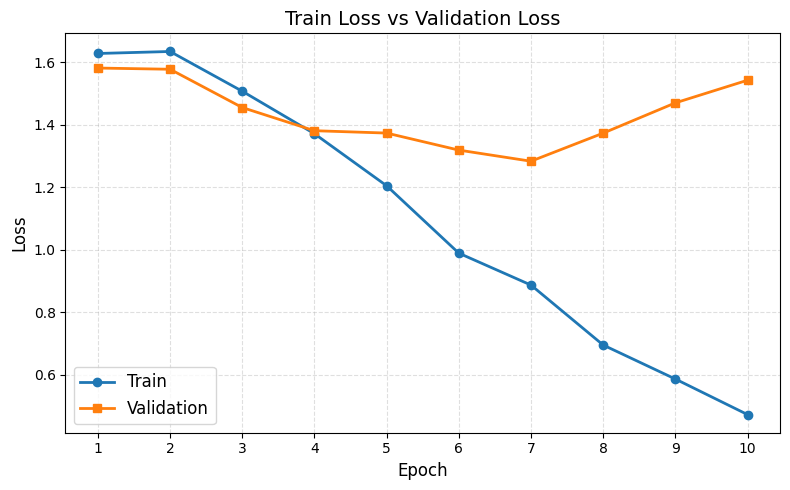

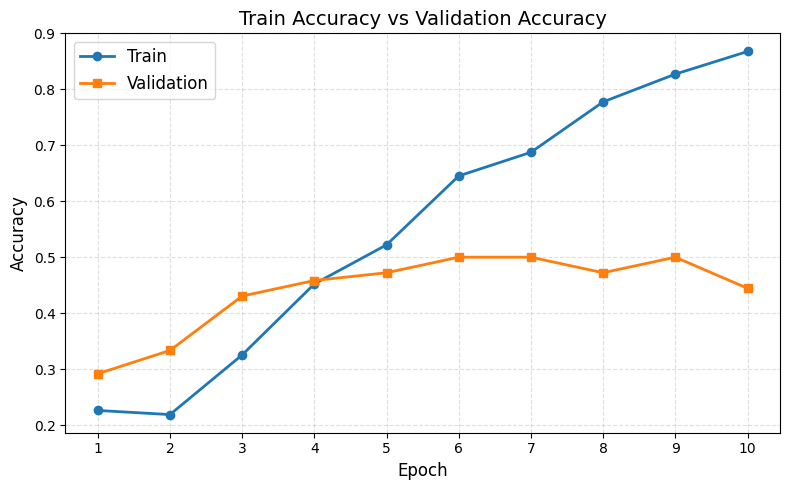

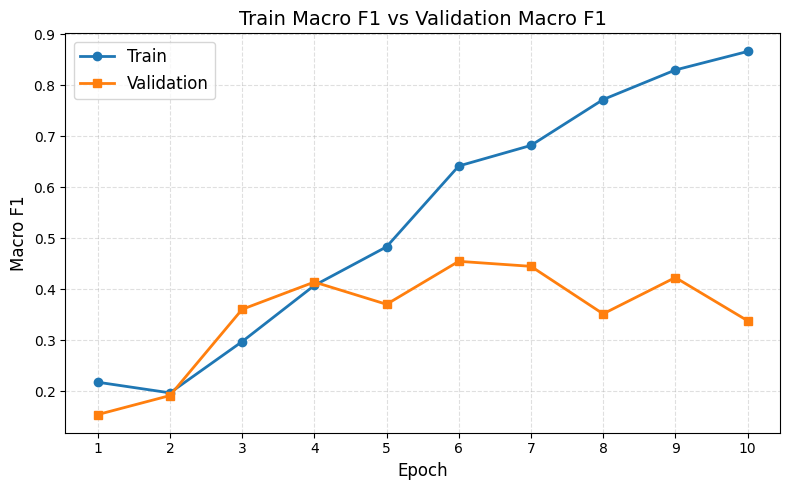

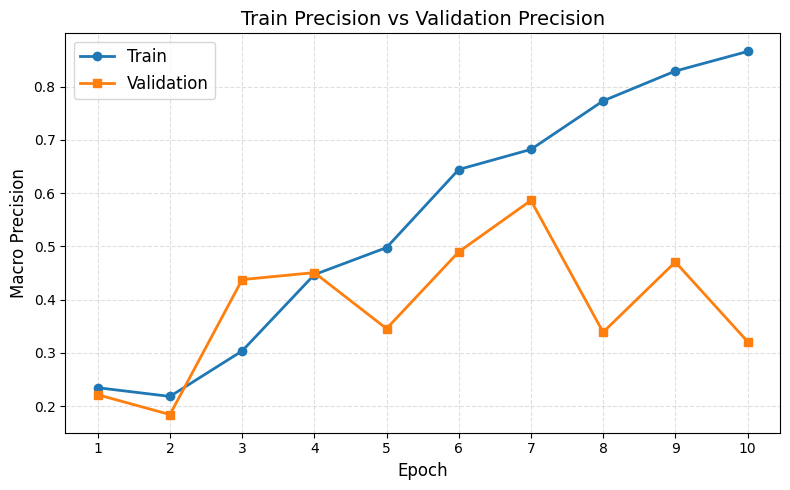

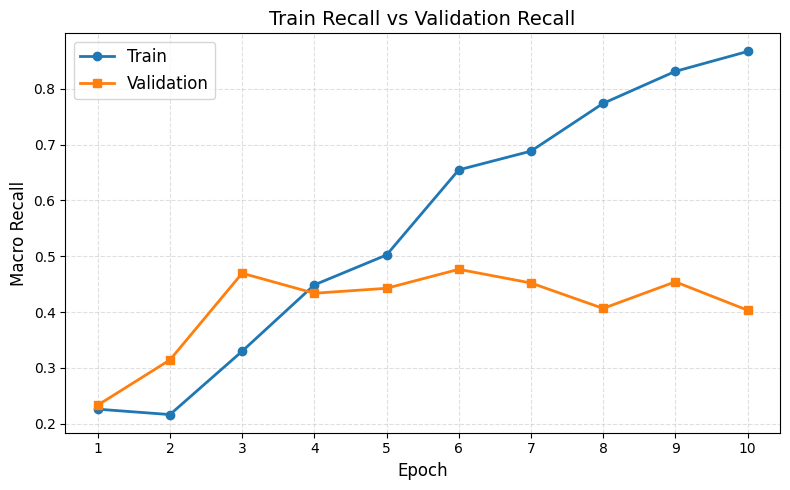

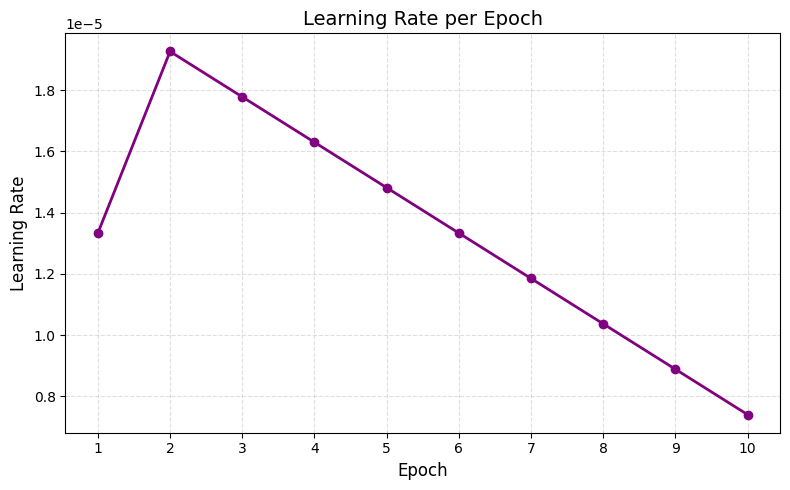

📈 Semua grafik perbandingan sudah ditampilkan!


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_compare(train_values, val_values, title, ylabel):
    plt.figure(figsize=(8,5))
    epochs = np.arange(1, len(train_values) + 1)

    plt.plot(epochs, train_values, marker='o', linewidth=2, label='Train')
    plt.plot(epochs, val_values, marker='s', linewidth=2, label='Validation')

    plt.title(title, fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(epochs)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()


# =======================================
#               LOSS
# =======================================
plot_compare(
    history["train_loss"], history["val_loss"],
    "Train Loss vs Validation Loss",
    "Loss"
)

# =======================================
#              ACCURACY
# =======================================
plot_compare(
    history["train_acc"], history["val_acc"],
    "Train Accuracy vs Validation Accuracy",
    "Accuracy"
)

# =======================================
#                MACRO F1
# =======================================
plot_compare(
    history["train_f1"], history["val_f1"],
    "Train Macro F1 vs Validation Macro F1",
    "Macro F1"
)

# =======================================
#              PRECISION
# =======================================
plot_compare(
    history["train_prec"], history["val_prec"],
    "Train Precision vs Validation Precision",
    "Macro Precision"
)

# =======================================
#               RECALL
# =======================================
plot_compare(
    history["train_rec"], history["val_rec"],
    "Train Recall vs Validation Recall",
    "Macro Recall"
)

# =======================================
#          LEARNING RATE CURVE
# =======================================
plt.figure(figsize=(8,5))
epochs = np.arange(1, len(history["lr"]) + 1)
plt.plot(epochs, history["lr"], marker='o', color='purple', linewidth=2)

plt.title("Learning Rate per Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Learning Rate", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.4)
plt.xticks(epochs)
plt.tight_layout()
plt.show()

print("📈 Semua grafik perbandingan sudah ditampilkan!")
